# Subtraction Algorithm tutorial

This tutorial shows how to estimate the Galactic foregound of Galactic binaries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from corner import corner
from fast_lisa_subtraction import GalacticBinaryPopulation, SourceCatalog, SubtractionAlgorithm

# Specify the device to use for computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Simulate a DWD Population

We first use the `GalacticBinaryPopulation` class to draw samples of a DWD Population.

This class uses the the parametrization explained in [De Santi F. et al (2026)](https://arxiv.org/abs/2602.18560) and is by default initialized to a fit to the catalog of [Lamberts A. et al. (2019)](https://academic.oup.com/mnras/article/490/4/5888/5585418) which we will use for this example.

In [2]:
# Instantiate the GalacticBinaryPopulation class
GB_population = GalacticBinaryPopulation(device=device)

# Generate samples from the population
N = int(7e6)
GB_population_samples = GB_population.sample(N)

# Convert to a dataframe and inspect the columns
GB_population_df = GB_population_samples.dataframe()

We then can plot the distribution in $(f, \dot{f}, \mathcal{A})$

[WARNING] - Too few points to create valid contours


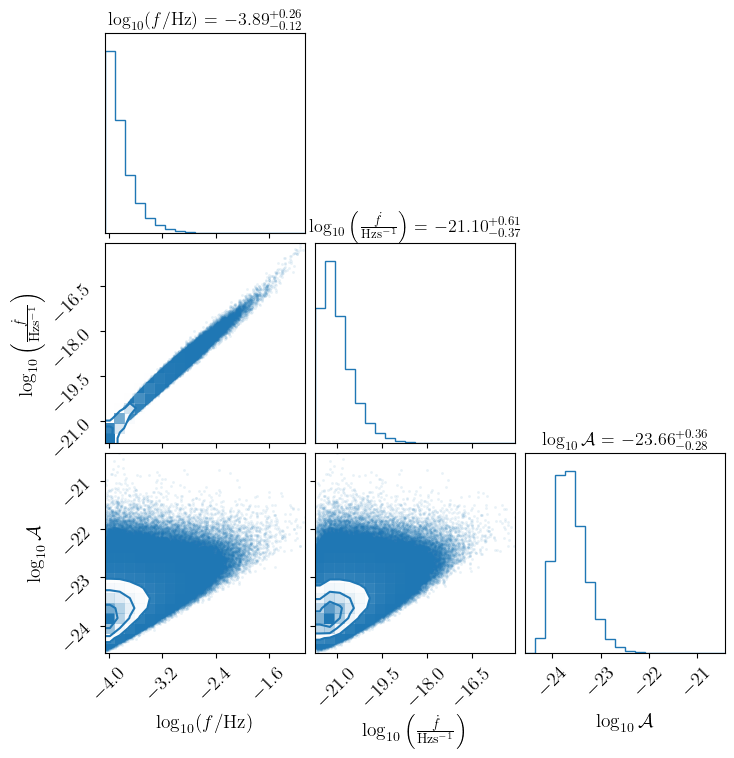

In [3]:
samples_numpy = GB_population_samples.numpy()
plot_samples = np.log10(samples_numpy[:, [0, 1, 2]]) 

fig = corner(plot_samples, 
             labels=[r'$\log_{10}(f/{\rm Hz})$', r'$\log_{10}\left(\frac{\dot{f}}{{\rm Hzs^{-1}}}\right)$', r'$\log_{10}\mathcal{A}$'], 
             show_titles=True, color='C0', title_kwargs={'fontsize': 13})

### Sources generation

We now generate the sources from the catalog above and inject into a LISA datastream.
We use `SourceCatalog` to generate and save the catalog. 

We need to specify:

- `Nmax_binaries`: Number of sources to generate. If `None`, the full catalog is generated.

- `Nbatch`: Number of sources processed per batch. This is useful to control memory usage, especially when running on GPU.

- `Tobs`: Observation time (in years).  
  
- `AET`: If `True`, the output is provided in the AET TDI basis.vOtherwise, the output may be in the XYZ basis.

- `save`: If `True`, the generated catalog and/or time series are saved to disk.

- `oversample`: Oversampling factor used when generating the time series.

- `tdi2`: If `True`, second-generation TDI (TDI 2.0) is used.

- `outdir`: Output directory where generated files will be stored.


This return as an output a dictionary with all the metadata and the TDI channels

In [10]:
catalog = SourceCatalog(catalog_df=GB_population_df, use_gpu=True if device=='cuda' else False)

AET = catalog.generate_catalogue(
    Nmax_binaries = None, 
    Nbatch        = 10000,
    Tobs          = 4,
    AET           = True,
    save          = True,
    oversample    = 1,
    tdi2          = True, 
    outdir        = os.getcwd(),
)

catalog_path = os.path.join(os.getcwd(), f'GB_catalogue_{N}_binaries.h5')
tdi_data_path = os.path.join(os.getcwd(), f'tdi_cat_GB_catalogue_{N}_binaries.h5')

[INFO] - Cupy is available: using the GPU
Generating waveforms: 100%|██████████| 700/700 [00:06<00:00, 102.46it/s]
[INFO] - Saving the catalogue with 7000000 binaries
[INFO] - TDI catalogue saved in /home/fdesanti/work/LISA/fast-lisa-subtraction/examples/tdi_cat_GB_catalogue_7000000_binaries.h5
[INFO] - Catalogue saved in /home/fdesanti/work/LISA/fast-lisa-subtraction/examples/GB_catalogue_7000000_binaries.h5


In [11]:
AET

{'A': array([ 6.56596047e-15-1.56411744e-14j, -1.51980682e-14-5.03222289e-15j,
        -2.26717721e-15-1.23868115e-14j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'E': array([ 1.00297762e-14+1.32854742e-14j,  1.20677020e-14+1.85768499e-14j,
        -4.13275250e-15+5.53553918e-15j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'T': array([ 1.04152541e-15-2.61888947e-14j, -1.00204175e-14-1.21080498e-14j,
         2.76406318e-14+9.74976982e-15j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'f': array([0.00000000e+00, 7.92188395e-09, 1.58437679e-08, ...,
        3.33333151e-02, 3.33333230e-02, 3.33333309e-02], shape=(4207754,)),
 'df': 7.921883946719446e-09,
 'dt': 15,
 'Tobs': 126232599.05418241,
 'tdi2':

## Running the Subtraction

We now run the subtraction algorithm. It returns:

- `out`: output object containing the resolved sources and related products (e.g. waveforms / indices / parameters, depending on implementation)
- `PSD`: the estimated foreground (and/or residual) Power Spectral Density
- `cat_figs`: diagnostic figures produced during the run (if `doplot=True`)

We need to specify:

- `maxiter`: Maximum number of subtraction iterations.  

- `snr_threshold`: Signal-to-noise ratio threshold used to classify sources as *resolved*.  

- `kappa`: sources with initial `kappa`*`snr_threshold` snr are left out from the subtraction. Assumes `kappa` <= 1

- `doplot`: If `True`, generates diagnostic plots during/after the run and returns them in `cat_figs`.

- `batch_size`: Number of sources processed per internal batch during the subtraction step.  

- `methoduse`: Method usedto estimate the PSD (either "mean" or "median")

- `extra_smooth`: Additional smoothing strategy applied to the PSD estimate. For example "convolution" applies a kernel-based smoothing to reduce small-scale fluctuations.

- `Nsegments`: Number of segments used to estimate the PSD 

- `tol`: Convergence tolerance. The algorithm stops early if the change in the PSD drops below this value.

- `verbose`: If `True`, prints progress information and iteration diagnostics.



[INFO] - Cupy is available: using the GPU
[INFO] - Reading catalogue data from /home/fdesanti/work/LISA/fast-lisa-subtraction/examples/GB_catalogue_7000000_binaries.h5
[INFO] - Catalogue contains 7000000 sources
/home/fdesanti/miniconda3/envs/lisa/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
[INFO] - Starting the local subtraction algorithm
[INFO] - Minimum SNR = 0.00005, maximum SNR = 3401.39
[INFO] - Selecting sources with SNR > 1.05
[INFO] - Selecting 88059/7000000 sources for subtraction
[INFO] - Initial PSD computed
[INFO] - Making initial plot
100%|==========================================| 88/88 [00:00<00:00, 241.60it/s]
[INFO] - Subtracted sources: 7509
[INFO] - 7509 source subtracted at iter 1.
[INFO] - New PSD computed
[INFO] - Making plot for iteration 1
100%|==========================================| 80/80 [00:00<00:00, 

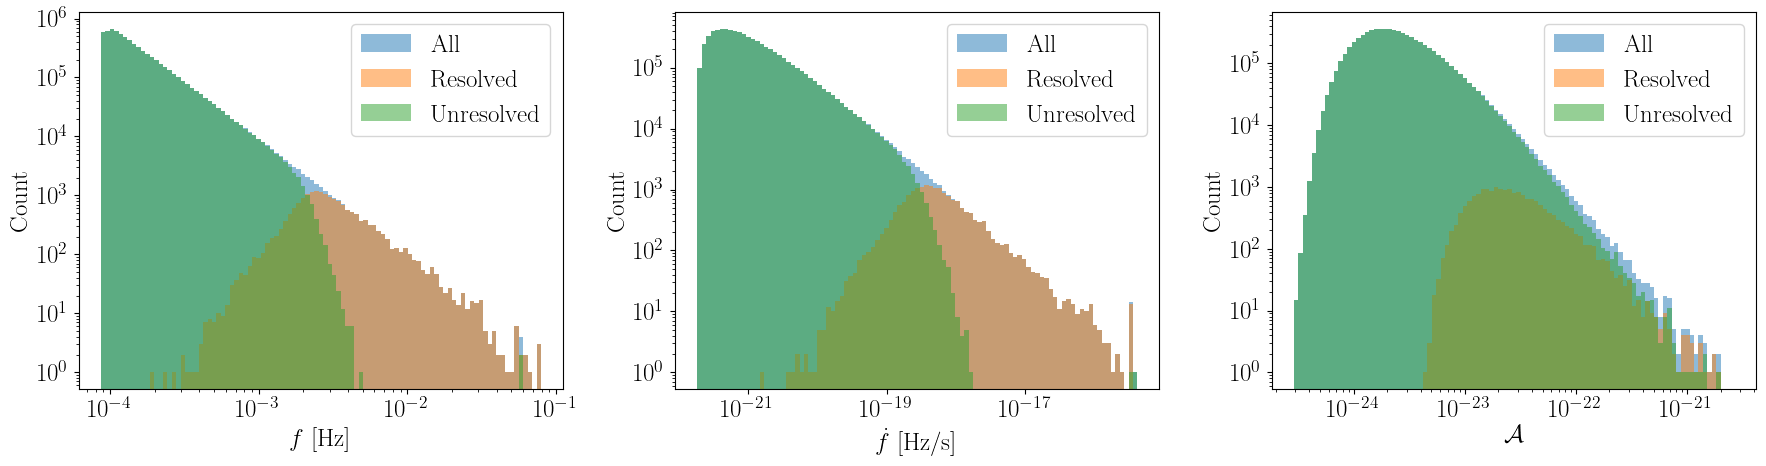

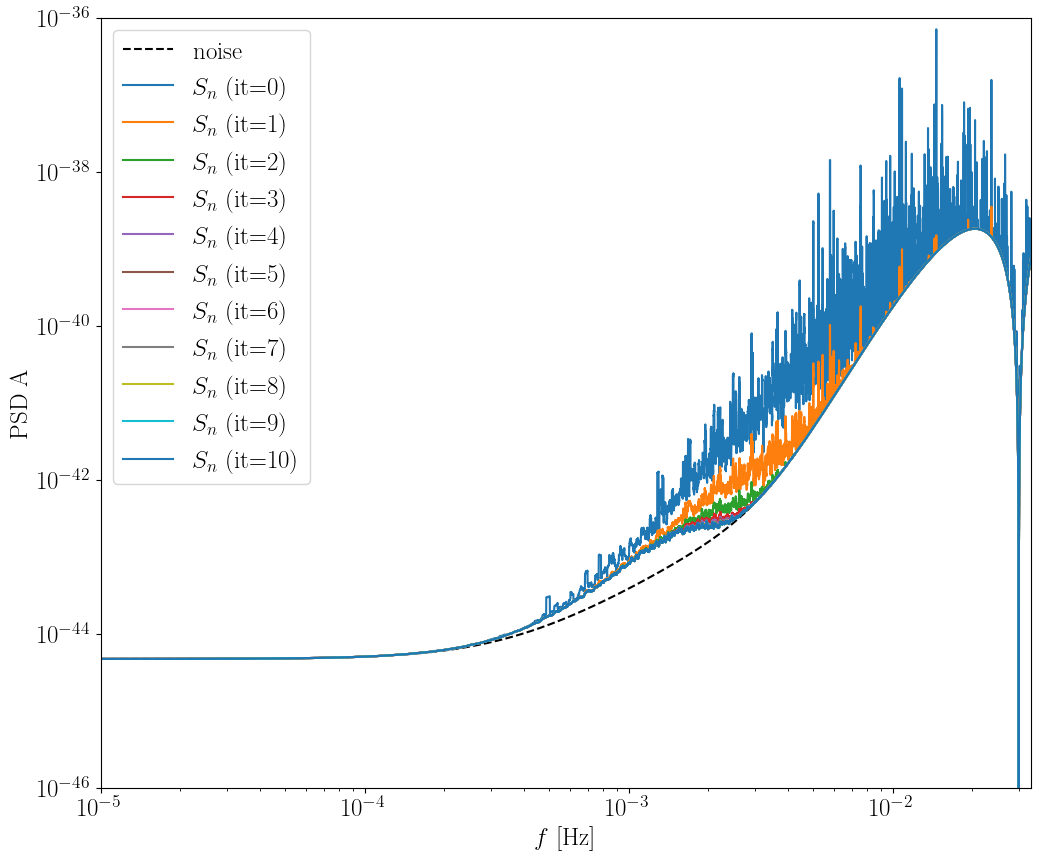

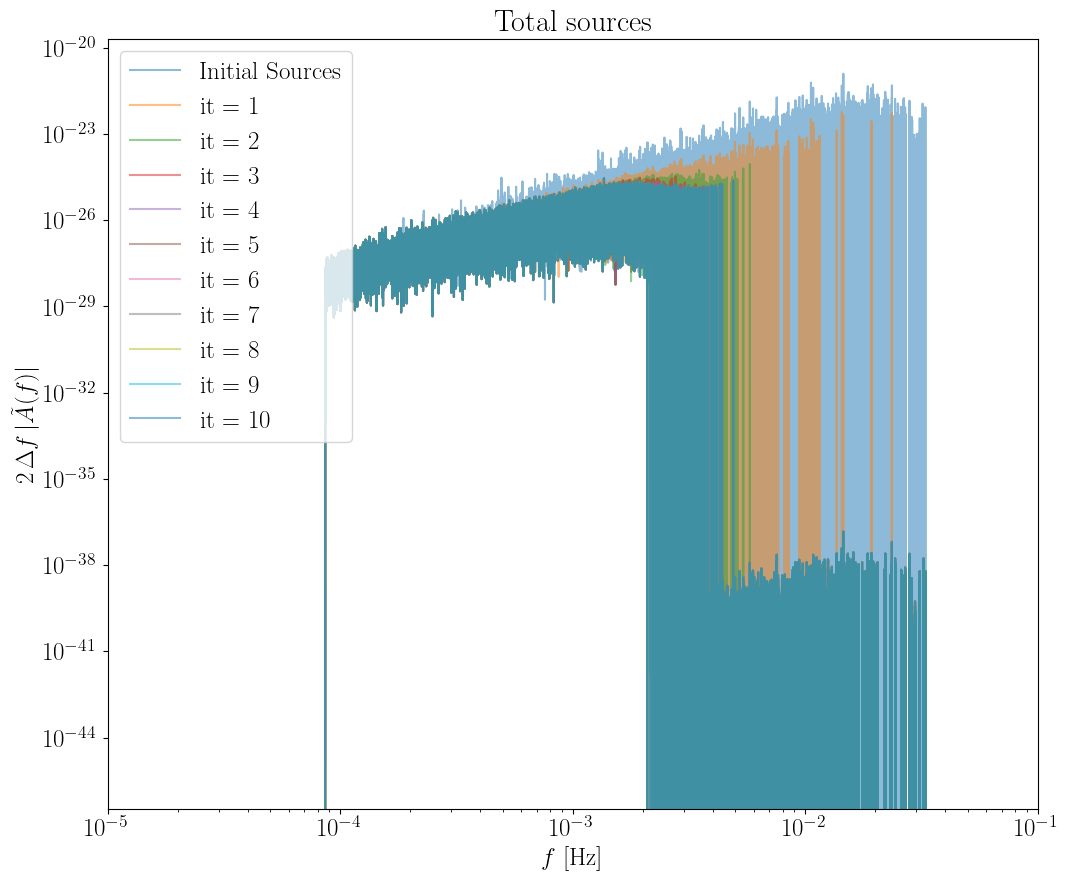

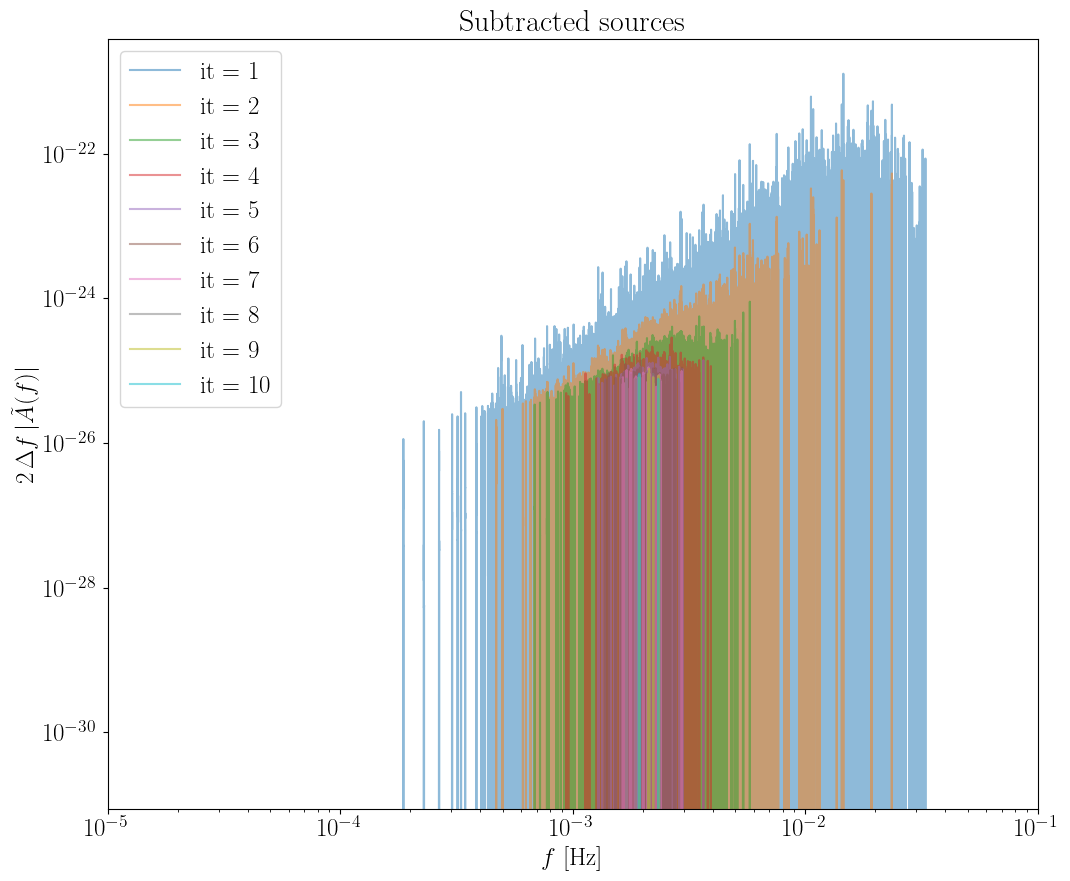

In [6]:
# Initialize the subtraction algorithm
subtract = SubtractionAlgorithm(catalog_path  = catalog_path, 
                                tdi_data_path = tdi_data_path ,
                                use_gpu       = True if device == 'cuda' else False)

# Run the subtraction
out, PSD, cat_figs = subtract.run(
      maxiter       = 10,
      snr_threshold = 7,
      kappa         = 0.15,
      doplot        = True,
      batch_size    = 1000,
      methoduse     = 'mean',
      extra_smooth  = "convolution",
      Nsegments = 2000,
      tol       = 1e-3,
      verbose   = True
)

display(cat_figs)

In [9]:
print(out.keys())
out

dict_keys(['A', 'E', 'T', 'Tobs', 'df', 'dt', 'duty_cycle', 'f', 'oversample', 'snr', 'tdi2', 'A_original', 'E_original', 'T_original', 'resolved_cat', 'unresolved_cat', 'num_sources', 'num_resolved', 'num_unresolved', 'runtime', 'iterations', 'Sconf'])


{'A': array([ 1.23750521e-17-1.21146037e-18j,  2.30985640e-18-1.13647080e-18j,
        -1.58123886e-17-8.88589963e-19j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'E': array([3.02035570e-18+3.23866884e-18j, 5.63116374e-18+2.33177858e-18j,
        4.34558100e-18+4.44667121e-19j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'T': array([1.33224648e-17-9.47084378e-18j, 1.80744821e-17+2.67857440e-17j,
        7.44929416e-18+1.43022934e-17j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j], shape=(4207754,)),
 'Tobs': array(1.26232599e+08),
 'df': array(7.92188395e-09),
 'dt': array(15),
 'duty_cycle': array(1),
 'f': array([0.00000000e+00, 7.92188395e-09, 1.58437679e-08, ...,
        3.33333151e-02, 3.33333230e-02, 3.33333309e-02], shap